In [1]:
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.display import HTML
import xarray as xr
import glob

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import wrapSpectra, spectra, sat, plot_sat, model
from lib.config import * 


# Validation CFOSAT Forecast - WW3 spectral station

In [2]:
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))
ds = xr.open_dataset(op.join(p_output, 'energy_BINS.nc'))

In [3]:
dataset = xr.open_dataset(op.join(p_output, 'params_BINS.nc'))

# spectral forecast 
spec = model.spec_st_ndays('W1765S135')

In [4]:
glob.glob(op.join(ww3_spectra_path, 'W17*'))

['/home/datawork-WW3/FORECAST/GLOBMULTI/GLOB-30M/SPEC_NC/best_estimate_hourly/2021/W1780S140',
 '/home/datawork-WW3/FORECAST/GLOBMULTI/GLOB-30M/SPEC_NC/best_estimate_hourly/2021/W1760S130',
 '/home/datawork-WW3/FORECAST/GLOBMULTI/GLOB-30M/SPEC_NC/best_estimate_hourly/2021/W1785S145',
 '/home/datawork-WW3/FORECAST/GLOBMULTI/GLOB-30M/SPEC_NC/best_estimate_hourly/2021/W1765S135']

In [5]:
days = 15 
fore_time = [forecast_day + datetime.timedelta(hours=3*i) for i in range(days*24)]

In [6]:
figsize = (15,10)
nframes = 2
var = 'H_sinNu'
ani = model.animation_val(spec, ds, dataset, fore_time,var,  nframes, figsize)


In [7]:
HTML(ani.to_jshtml())

In [8]:
sys.exit()

SystemExit: 

## Plot daily arriving energy 

In [6]:
# Satellite
ds_comb = xr.combine_by_coords([dataset, ds])[['time', 'Ttime', 'H_sinNu', 'bearing1']]
df_cfosat = ds_comb.to_dataframe().dropna().reset_index()
df_cfosat['date'] = pd.to_timedelta(df_cfosat['Ttime'], unit='s') + df_cfosat['time']
df_cfosat = df_cfosat.drop(columns={'posneg', 'nbox'}).sort_values('H_sinNu')

In [7]:
# Model
df_model = spec[['efth']].to_dataframe().reset_index().dropna().drop(columns='station').sort_values('efth')
df_model['direction'] = model.fix_dir(df_model.direction.values)

**Plot scatter arrival of energy**

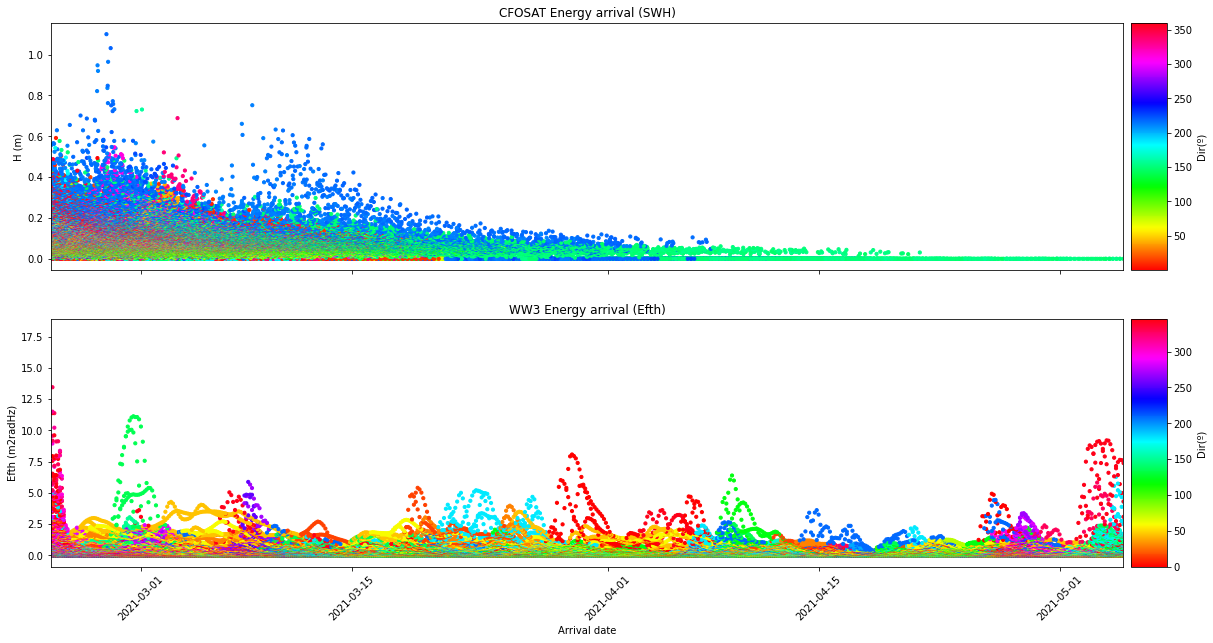

In [8]:
cmap='rainbow'

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)

# CFOSAT
im0 = axs[0].scatter(df_cfosat.date.values, df_cfosat.H_sinNu.values, c=df_cfosat['bearing1'].values, s=10, cmap='hsv')

# WW3
im1 = axs[1].scatter(df_model.time.values, df_model['efth'].values, c=df_model['direction'].values, s=10, cmap='hsv')

# axis
axs[0].set_title('CFOSAT Energy arrival (SWH)')
axs[0].set_ylabel('H (m)')

axs[1].set_title('WW3 Energy arrival (Efth)')
axs[1].set_ylabel('Efth (m2radHz)')
axs[1].set_xlabel('Arrival date')
axs[1].set_xlim(forecast_day, df_cfosat.date.values.max())
plt.xticks(rotation=45)
    
# colorbar
axc0, loc = plot_sat.add_colorbar(axs[0])
axc1, loc = plot_sat.add_colorbar(axs[1])

fig.add_axes(axc0)
fig.add_axes(axc1)

plt.colorbar(im0,  cax=axc0, label='Dir(º)')
plt.colorbar(im1,  cax=axc1, label='Dir(º)')
plt.show() 


**Plot scatter arrival of energy in terms of Efth-H and Direction**

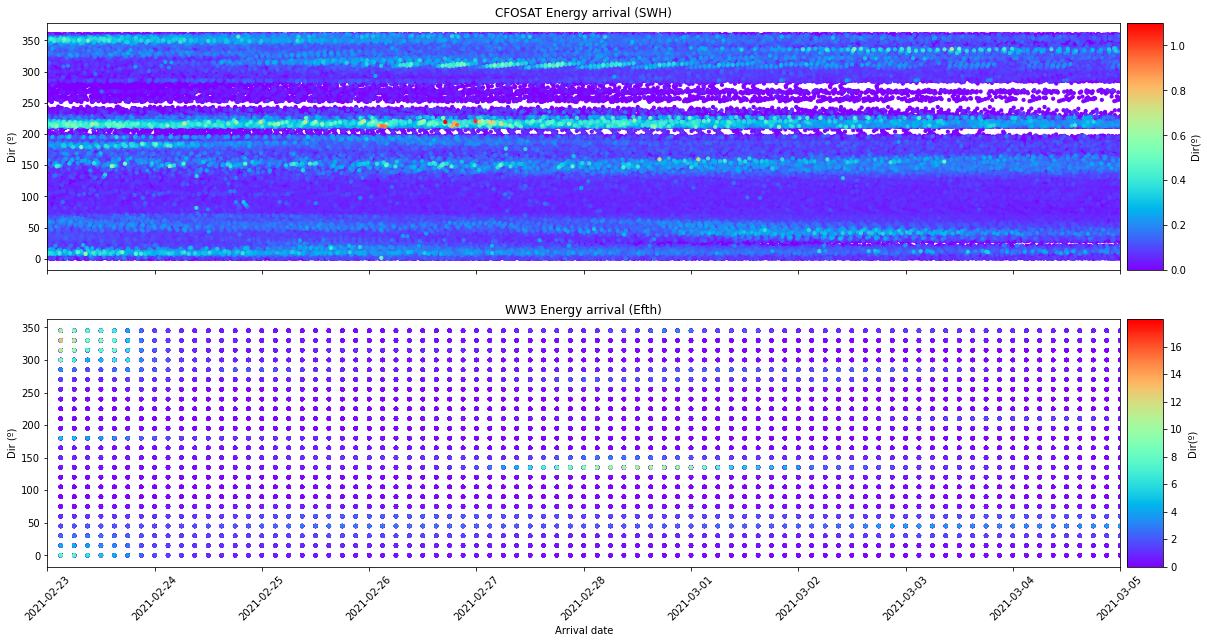

In [9]:
cmap='rainbow'

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)

# CFOSAT
im0 = axs[0].scatter(df_cfosat.date.values, df_cfosat.bearing1.values, c=df_cfosat['H_sinNu'].values, 
                     s=10, cmap=cmap)

# WW3
im1 = axs[1].scatter(df_model.time.values, df_model['direction'].values, c=df_model['efth'].values, 
                     s=10, cmap=cmap)

# axis
axs[0].set_title('CFOSAT Energy arrival (SWH)')
axs[0].set_ylabel('Dir (º)')

axs[1].set_title('WW3 Energy arrival (Efth)')
axs[1].set_ylabel('Dir (º)')
axs[1].set_xlabel('Arrival date')
axs[1].set_xlim(forecast_day, forecast_day+datetime.timedelta(days=10))
plt.xticks(rotation=45)
    
# colorbar
axc0, loc = plot_sat.add_colorbar(axs[0])
axc1, loc = plot_sat.add_colorbar(axs[1])

fig.add_axes(axc0)
fig.add_axes(axc1)

plt.colorbar(im0,  cax=axc0, label='Dir(º)')
plt.colorbar(im1,  cax=axc1, label='Dir(º)')
plt.show() 


**Pcolor plot discretised to 15º and 12 hours**

In [22]:
import matplotlib.dates as mdates
var = 'H_sinNu'

df_cfosat['date2num'] = mdates.date2num(df_cfosat['date'])
df_model['date2num'] = mdates.date2num(df_model['time'])

# count bins
time_ini, time_fin = forecast_day, forecast_day+datetime.timedelta(days=10)
bins_dirs = np.arange(0, 360+15, 15)
bins_date = np.linspace(mdates.date2num(time_ini), mdates.date2num(time_fin), 40)
bins_k = np.sort(spec.frequency.values)

# Convert k -> frequency, H - Efth
df_cfosat['freq'] = 1/np.sqrt(4*np.pi**2/(df_cfosat['k']*g))
df, do = np.diff(bins_k)[0], np.diff(bins_dirs)[0]
df_cfosat['Efth'] = (df_cfosat[var]**2/16)/(df*do*2*np.pi/360)

def count_bins(df_cfosat, bins_dirs, bins_date, var_x, var_y, var_z):
    matrix = np.zeros((len(bins_dirs), len(bins_date)))

    for pr, row in enumerate(bins_dirs[:-1]):
        for pc, col in enumerate(bins_date[:-1]):
            subset = df_cfosat.loc[(df_cfosat[var_x] >= row) & (df_cfosat[var_x] < bins_dirs[pr+1]) & (df_cfosat[var_y] >= col) & (df_cfosat[var_y] < bins_date[pc+1])]
            subset = subset.loc[subset.Efth != 0]
            matrix[pr, pc] = np.nanmean(subset[var_z].values)
            if np.isnan(matrix[pr, pc]): matrix[pr, pc] = 0
                
    return(matrix)

# sat
ma_sat = count_bins(df_cfosat, bins_dirs, bins_date, 'bearing1', 'date2num', 'Efth')

# model
ma_model = count_bins(df_model, bins_dirs, bins_date, 'direction', 'date2num', 'efth')


AttributeError: 'DataFrame' object has no attribute 'Efth'

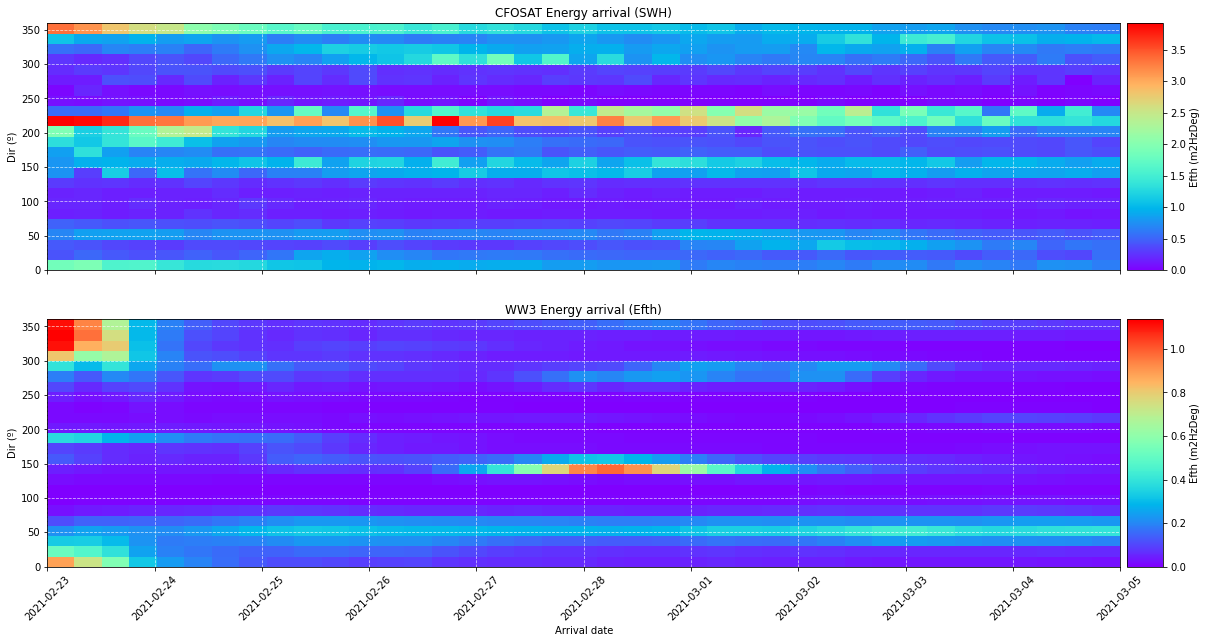

In [24]:
cmap='rainbow'

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)
vmin, vmax = 0, np.nanmax([np.nanmax(ma_model), np.nanmax(ma_sat)])

# CFOSAT
im0 = axs[0].pcolor(mdates.num2date(bins_date), bins_dirs, ma_sat, cmap=cmap, vmin=0, vmax=None)

# WW3
im1 = axs[1].pcolor(mdates.num2date(bins_date), bins_dirs, ma_model, cmap=cmap, vmin=0, vmax=None)

# axis
axs[0].set_title('CFOSAT')
axs[0].set_ylabel('Dir (º)')

axs[1].set_title('WW3')
axs[1].set_ylabel('Dir (º)')
axs[1].set_xlabel('Arrival date')
axs[1].set_xlim(time_ini, time_fin)
plt.xticks(rotation=45)
    
axs[0].grid(linewidth=0.8, color='w', alpha=0.7, linestyle='--')
axs[1].grid(linewidth=0.8, color='w', alpha=0.7, linestyle='--')

# colorbar
axc0, loc = plot_sat.add_colorbar(axs[0])
axc1, loc = plot_sat.add_colorbar(axs[1])

fig.add_axes(axc0)
fig.add_axes(axc1)

plt.colorbar(im0,  cax=axc0, label='Efth (m2HzDeg)')
plt.colorbar(im1,  cax=axc1, label='Efth (m2HzDeg)')
plt.show() 
